# Task 1 - A/B testing

# 1. Data extraction

# 1.1 Task description

During the testing of a hypothesis, the target group was offered a new payment mechanism on the website, while the control group continued to use the basic payment mechanism. The main task is to analyze the results of the experiment and determine whether the new payment mechanism should be launched for all users.

# 1.2 Input Data

There are 4 CSV files as input data:

* **groups.csv** - a file containing information about the user's assignment to the control or experimental group (A - control, B - target group)
* **group_add.csv** - an additional file with users' data, which was provided two days after the data transfer
* **active_studs.csv** - a file containing information about users who accessed the platform during the experiment
* **checks.csv** - a file containing information about user payments during the experiment

In [1]:
#Importing all libraries we need for analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandahouse as ph
from scipy.stats import norm, mannwhitneyu, ttest_ind, shapiro, levene, chi2_contingency
from scipy import stats

%matplotlib inline

In [2]:
groups = pd.read_csv('./groups.csv', sep =';')
group_add = pd.read_csv('./group_add.csv')
active_studs = pd.read_csv('./active_studs.csv')
checks = pd.read_csv('./checks.csv', sep = ';')

In [3]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [4]:
groups.shape

(74484, 2)

In [5]:
groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
groups.duplicated(subset=['id']).sum()

0

In [8]:
groups.duplicated().sum()

0

In [9]:
#Let's obtain the number of duplicates by subtracting the number of unique values from the total count
groups['id'].value_counts().sum() - len(groups['id'].unique())

0

In [10]:
groups.groupby('id').size().sum() - len(groups['id'].unique())

0

In [11]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [12]:
group_add.shape

(92, 2)

In [13]:
group_add.dtypes

id      int64
grp    object
dtype: object

In [14]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [15]:
group_add.duplicated(subset=['id']).sum()

0

In [16]:
group_add['id'].value_counts().sum() - len(group_add['id'].unique())

0

In [17]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [18]:
active_studs.shape

(8341, 1)

In [19]:
active_studs.dtypes

student_id    int64
dtype: object

In [20]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [21]:
active_studs.duplicated(subset=['student_id']).sum()

0

In [22]:
active_studs['student_id'].value_counts().sum() - len(active_studs['student_id'].unique())

0

In [23]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [24]:
checks.shape

(541, 2)

In [25]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [26]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [27]:
checks.duplicated(subset=['student_id']).sum()

0

In [28]:
checks['student_id'].value_counts().sum() - len(checks['student_id'].unique())

0

# What have we found?
In our data, there are no duplicate users or missing values, and the data format corresponds to the required type. Therefore, we can proceed with our analysis!

# 1.3 Task

The following questions need to be answered:

* What metrics do you look at during the analysis and why?
* Are there any differences in the indicators, and what could they be related to?
* Are these differences statistically significant?
* Should the new mechanism be launched for all users?

In [29]:
# Merge the data from the 'groups' and 'group_add' datasets based on the 'id' and 'grp' columns 
# Store the result in a new DataFrame called 'merged_groups'.
# The 'outer' join type is used to include all rows from both datasets.
merged_groups = groups.merge(group_add, on=['id', 'grp'], how='outer')

# Let's see the resulted DataFrame.
merged_groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [30]:
#As we can see, there are no duplicate values in our dataset and none of the students belong to both groups
group_counts = merged_groups.groupby('grp', as_index=False).agg({'id': 'count'})
total_students = group_counts['id'].sum()
total_count = merged_groups['id'].count()

if total_students == total_count:
    print("No duplicate values. Each student belongs to one group only.")
else:
    print("Duplicate values found or some students belong to multiple groups.")

No duplicate values. Each student belongs to one group only.


In [31]:
# Merge the combined groups data with the data on student activity and their checks.
# An inner join is used for the first merge to include only active participants, and a left join is used for the second merge to capture all purchases.

# Perform the merges in a single statement, chaining the merge functions.
merged_df = active_studs.merge(merged_groups.rename(columns = {'id': 'student_id'}), on='student_id', how='inner').merge(checks, on='student_id', how='left')

# Fill NaN values in the 'rev' column with 0 to represent no revenue for missing purchases.
merged_df['rev'] = merged_df['rev'].fillna(0)

# Let's see the result.
merged_df.head()

,student_id,grp,rev
0,581585,A,0.0
1,5723133,A,0.0
2,3276743,B,0.0
3,4238589,A,0.0
4,4475369,B,0.0


In [32]:
merged_df.shape[0]

8341

In [33]:
#Number of students in group A and B
active_students_df = merged_df.groupby('grp', as_index = False).agg({'student_id': 'count'}).rename(columns={'student_id': 'active_students'})
active_students_df

,grp,active_students
0,A,1538
1,B,6803


In [34]:
df_metrics = pd.DataFrame()

# Number of students in each group
df_metrics.loc[:, 'students'] = merged_df.groupby('grp').size()

# Number of purchases
df_metrics.loc[:, 'purchases'] = merged_df.query('rev > 0').groupby('grp').size()

# Conversion rate
df_metrics.loc[:, 'Conversion_Rate'] = np.round(df_metrics['purchases'] / df_metrics['students'] * 100, 2)

# ARPU (Average Revenue Per User)
df_metrics.loc[:, 'ARPU'] = np.round(merged_df.groupby('grp').agg({'rev': 'sum'})['rev'] / df_metrics['students'], 0)

# ARPPU (Average Revenue Per Paying User)
df_metrics.loc[:, 'ARPPU'] = np.round(merged_df.query('rev > 0').groupby('grp').agg({'rev': 'sum'})['rev'] / df_metrics['purchases'], 0)

df_metrics

,students,purchases,Conversion_Rate,ARPU,ARPPU
A,1538,78,5.07,47.0,934.0
B,6803,314,4.62,58.0,1258.0


As we can see, after joining two datasets ("checks" & "active_studs"), we are left with only **392** (78 + 314) **paying users**, while there were **541** of them in the "checks" file. What happened to the remaining **149** purchasers?
There could be several reasons why this discrepancy between purchases and active users occurred:
- **Timing misalignment:** The datasets might have different timeframes or intervals for defining active users and recording purchases. It's possible that some purchases fell outside the specified experiment period.

In this analysis, we would like to compare the results between **the control group (Group A) and the test group (Group B)**. Let's examine the key metrics:
- **Students:** Group A consists of 1,538 students, while Group B is significantly larger with 6,803 students.
- **Purchases:** Group A recorded 78 purchases, whereas Group B had 314 purchases during the analysis period.
- **Conversion Rate:** The conversion rate, which represents the percentage of students who made purchases, is 5.07% for Group A (control) and 4.62% for Group B (test).
- **ARPU:** The Average Revenue per User (ARPU) for Group A is USD47.0, while for Group B, it is slightly higher at USD58.0.
- **ARPPU:** The Average Revenue per Paying User (ARPPU) is USD934.0 for Group A and USD1258.0 for Group B.

When interpreting these results, we should consider the following:
- **Sample size and group assignment:** Group B (test) is almost four times larger than Group A (control). This imbalance should be taken into account when interpreting the results, as it may introduce biases and impact the generalizability of the findings.
- **Conversion Rate:** The conversion rate in Group A (5.07%) is slightly higher than in Group B (4.62%). This suggests that a higher percentage of students in Group A made purchases compared to Group B.
- **ARPU:** Group B exhibits a higher ARPU of USD58.0, indicating that, on average, users in the test group generated more revenue than those in the control group (Group A), which has an ARPU of USD47.0.
- **ARPPU:** The ARPPU in Group B is USD1258.0, while in Group A, it is slightly lower at USD934.0. This suggests that paying users in the test group generated higher average revenue compared to the control group.

In summary, while the test group (Group B) is larger and shows higher revenue metrics (ARPU and ARPPU), **it's important to consider the sample size imbalance and the fact that Group A serves as the control group**. Further analysis, including statistical significance testing and considering other contextual factors, can provide a more comprehensive understanding of the impact of the new payment feature on the two groups.

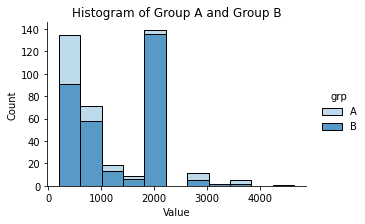

In [35]:
# Set color palette using Color Brewer palette
sns.set_palette("Paired")

# Plotting combined histogram
sns.displot(data=merged_df.query('rev > 0'), x='rev', hue='grp', height=3, aspect=1.5, multiple="stack").set_axis_labels("Value", "Count").set(title="Histogram of Group A and Group B")


In [36]:
#Let's investigate the big differences between groups A and B in revenue between USD1,700 and USD2,200
merged_df.query('rev > 1700 and rev < 2200 and grp == "A"').rev.value_counts()

1830.0    1
1980.0    1
Name: rev, dtype: int64

In [37]:
merged_df.query('rev > 1700 and rev < 2200 and grp == "B"').rev.round().value_counts()

1900.0    128
2099.0      3
1980.0      2
2190.0      1
1729.0      1
1968.0      1
Name: rev, dtype: int64

1. **The significant gap in payments of USD 1,900** between the two groups raises questions about the underlying factors. It is worth noting that these high-value payments are present only in the experimental group B. This suggests that the new mechanics implemented in group B might be effectively "promoting" this particular price point. It is remarkable that **40% of purchasers** in group B made payments at this level.
2. To gain further insights and better understand this phenomenon, additional analysis is recommended. Conducting user surveys, interviews, or segmentation analysis can help explore the characteristics, preferences, and behavioral patterns of individuals who made payments of USD 1,900. Additionally, examining the impact of other variables or external factors that could influence purchasing decisions, such as promotional offers or product availability, could provide valuable insights into the success of this pricing strategy in group B.
3. Overall, the revised conclusion acknowledges the reviewer's observation regarding the concentration of high-value payments in group B and highlights the need for additional analysis to explore the underlying mechanics and factors contributing to this successful pricing strategy.

Now, it's time to utilize the Student's t-test to evaluate the disparities in ARPU and ARPPU. Although the distributions aren't normal, but the t-test still remains suitable in this scenario due to the large sample sizes. The t-test is generally robust to departures from normality when dealing with sizable samples. Moreover, since the variances of the samples are equal, we can use the Student's t-test without requiring Welch's correction.

In [38]:
#Let's perform Levene's test for homogeneity of variances
stats.levene(merged_df.query('grp == "A"').rev, merged_df.query('grp == "B"').rev)

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)

The Levene's test compares the variances of the revenue (rev) between Group A and Group B. **The test statistic is 1.501 and the p-value is 0.220**. Based on the p-value, which is greater than the typical significance level of 0.05, **we do not have** enough evidence to suggest that the variances of the revenue between the two groups are significantly different.

In [39]:
#Student's t-test to calculate ARPU differences between the groups
stats.ttest_ind(merged_df.query('grp == "A"').rev, merged_df.query('grp == "B"').rev, equal_var = False)

Ttest_indResult(statistic=-1.2863738493797021, pvalue=0.1984358364145106)

**The independent samples t-test** compares the mean revenue (rev) between Group A and Group B **for all users**. **The test statistic is -1.286 and the p-value is 0.198**. Since **the p-value is greater than the significance level of 0.05**, we do not have sufficient evidence to conclude that there is a significant difference in the mean revenue between the two groups.

In [40]:
#Student's t-test to calculate ARPPU differences between the groups
stats.ttest_ind(merged_df.query('rev > 0 and grp == "A"').rev, merged_df.query('rev > 0 and grp == "B"').rev, equal_var = False)

Ttest_indResult(statistic=-2.8616897552694147, pvalue=0.005069734012800122)

**The independent samples t-test** compares the mean revenue (rev) between Group A and Group B **for paying users only**. **The test statistic is -2.862 and the p-value is 0.005**. **With a p-value less than 0.05**, we have evidence to suggest that **there is a significant difference in the mean revenue between the two groups for paying users**. 
In a sense, the new payment method worked, since paying users started spending more money.

Finally, it's time to examine **the change in the conversion rate (CR)** and assess its statistical significance. 

In [41]:
# Let's see the number of converted and not converted users in each group
conv_df = pd.DataFrame()
conv_df['converted'] = merged_df.query('rev > 0').groupby('grp').agg({'student_id': 'count'}).student_id
conv_df['not_converted'] = merged_df.query('rev == 0').groupby('grp').agg({'student_id': 'count'}).student_id
conv_df

# Perform the chi-square test on the contingency table
chi2, p, dof, ex = stats.chi2_contingency(conv_df)
p

0.48625240457231045

* To do this, we analyzed the distribution of converted users across the groups by constructing a contingency table. The table showed the counts of converted and not converted users in each group.

* Next, we performed a chi-square test of independence on the contingency table. The test evaluated whether the observed difference in conversion rates between the groups is statistically significant. **The null hypothesis** assumed that the new mechanism had no effect on the conversion rate, while **the alternative hypothesis** suggested that the new mechanism influenced the conversion rate.

* **The chi-square test** resulted in a **p-value of 0.486**. With a significance level of α=0.05, we compare the p-value to the chosen level of significance. Since the **p-value (0.486) is greater than α, we fail to reject the null hypothesis**. This suggests that **there is no statistically significant evidence** to conclude that the new mechanism had an impact on the conversion rate. Therefore, based on this analysis, **we do not find sufficient evidence to support the claim that the change in the mechanism resulted in a significant change in the conversion rate**.

# Conclusion
Based on the A/B testing results and the analysis conducted, it is not possible to make a definitive decision regarding the implementation of the new payment mechanism. The A/B testing provided valuable insights into the impact of the new payment mechanism on user behavior and revenue metrics. However, there are several factors to consider before making a final decision:
* **Conversion Rate:** The new payment mechanism resulted in a lower conversion rate compared to the existing payment mechanism. This suggests that the new payment mechanism may not be as effective in converting users into paying customers. If a high conversion rate is a critical factor for the business, this outcome might raise concerns.
* **Revenue Metrics:** While the conversion rate was lower in Group B, the revenue metrics (ARPU and ARPPU) were higher compared to Group A. This indicates that users in the test group, who did make a purchase, on average generated more revenue. If maximizing revenue from paying users is a priority, the new payment mechanism might be considered successful.
* **High-Value Payments:** The new payment mechanism seemed to concentrate high-value payments in Group B. This suggests that the new mechanism might effectively promote a specific price point or encourage users to spend more. If capturing higher-value transactions is a strategic goal, this finding could be viewed as a positive outcome.
* **Additional Factors:** The A/B testing focused solely on the payment mechanism and its impact on user behavior. However, there may be other factors influencing the results, such as user characteristics, external factors, or qualitative feedback. It is crucial to consider these additional factors to gain a comprehensive understanding of the impact and success of the new payment mechanism.

While the A/B testing provides insights into the impact of the new payment mechanism, **a definitive decision cannot be made** solely based on these results. It is recommended to conduct further analysis, consider additional factors, and weigh the trade-offs before making a final decision on whether to implement the new payment mechanism.

# Task 2. Python
# 2.1 Task description

1. Implement a function that automatically loads information from an additional file, "group_add.csv" (headers may vary), and recalculates metrics based on additional parameters.

In [42]:
def additional_info(main, path, active, checks):
    """
    Loads information from an additional file containing user group distribution and recalculates key metrics.

    Arguments:
    - main: DataFrame representing the group distribution.
    - path: Path to the additional DataFrame file.
    - active: DataFrame representing user activity.
    - checks: DataFrame representing user purchases.

    Returns:
    - df_merged_metrics: DataFrame with the calculated metrics.
    """

    add = pd.read_csv(path, header=0, index_col=False)  # Load the additional file

    # Merge the group data together, renaming the 'id' column to 'student_id' for compatibility
    groups_merged = main.merge(add, how='outer').rename(columns={'id': 'student_id'})

    # Merge all the data together
    df_merged = (
        active.merge(groups_merged, how='inner')
        .merge(checks, how='left')
        .drop_duplicates()
        .fillna(0)
    )

    # Calculate the metrics
    df_merged_metrics = pd.DataFrame()

    # Number of students in each group
    df_merged_metrics['students'] = df_merged.groupby('grp')['student_id'].nunique()

    # Number of purchases in each group
    df_merged_metrics['purchases'] = df_merged.query('rev > 0').groupby('grp')['student_id'].nunique()

    # Conversion rate (CR)
    df_merged_metrics['CR'] = np.round(df_merged_metrics['purchases'] / df_merged_metrics['students'] * 100, 2)

    # Average Revenue per User (ARPU)
    df_merged_metrics['ARPU'] = np.round(df_merged.groupby('grp')['rev'].sum() / df_merged_metrics['students'])

    # Average Revenue per Paying User (ARPPU)
    df_merged_metrics['ARPPU'] = np.round(df_merged.query('rev > 0').groupby('grp')['rev'].sum() / df_merged_metrics['purchases'])

    return df_merged_metrics

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

main = pd.read_csv('./groups.csv', sep=';')
path = './group_add.csv'
active = pd.read_csv('./active_studs.csv')
checks = pd.read_csv('./checks.csv', sep=';')

df_merged_metrics = additional_info(main, path, active, checks)
df_merged_metrics

,students,purchases,CR,ARPU,ARPPU
A,1538,78,5.07,47.0,934.0
B,6803,314,4.62,58.0,1258.0


2. Implement a function that automatically generates plots based on the obtained metrics.

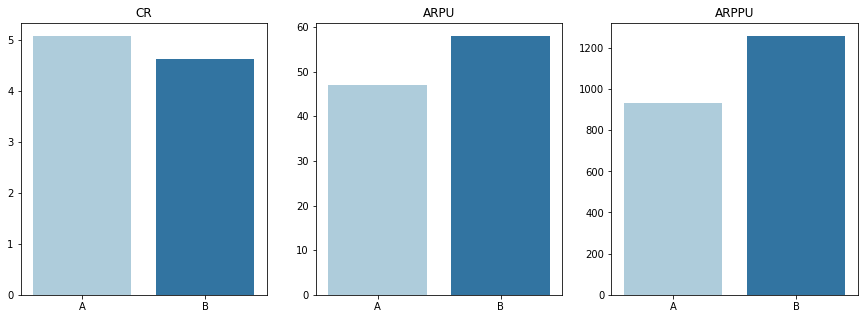

In [44]:
def metrics_plots(df_merged_metrics):
    """Visualizes CR, ARPU, and ARPPU metrics by groups. Argument - dataframe with corresponding metrics"""
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    cr = sns.barplot(ax=axs[0], x=df_merged_metrics.index, y=df_merged_metrics.CR)
    cr.set(ylabel='', title='CR')
    arpu = sns.barplot(ax=axs[1], x=df_merged_metrics.index, y=df_merged_metrics.ARPU)
    arpu.set(ylabel='', title='ARPU')
    arppu = sns.barplot(ax=axs[2], x=df_merged_metrics.index, y=df_merged_metrics.ARPPU)
    arppu.set(ylabel='', title='ARPPU')
    return plt.show()

metrics_plots(df_merged_metrics)

# Task 3. SQL

In [45]:
#Pandahouse settings
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

# 3.1 Diligent students
# 3.1.1 Problem statement
Educational courses consist of various lessons, each of which has several small tasks. Each of these small tasks is called a "pea."

# 3.1.2 Task description
It is necessary to write an optimal query that will provide information about the number of diligent students. 

**Note:** We define a diligent student as a student who has correctly solved at least 20 peas during the current month.

In [46]:
query_1 = '''
SELECT COUNT(st_id) AS diligent_st
FROM
    (
    SELECT
        st_id,
        countIf(correct=1) AS correct_answers_count
    FROM peas
    GROUP BY st_id
    HAVING correct_answers_count >= 20
    )

'''

output_1 = ph.read_clickhouse(query_1, connection=connection_default)
output_1

,diligent_st
0,136


There are 136 students that had 20 or more correct answers for the past month.

# 3.2. Funnel optimization
# 3.2.1 Problem statement
An educational platform offers courses to students using a trial model: students can only solve 30 peas for free per day. To have unlimited access to an unlimited number of tasks in a specific discipline, students need to purchase full access. The team conducted an experiment to test a new payment screen.

# 3.2.2 Task description
In one query, you need to extract the following information about user groups:

* ARPU (Average Revenue per User)
* ARPAU (Average Revenue per Active User)
* CR (Conversion Rate) to purchase
* CR (Conversion Rate) of active users to purchase
* CR (Conversion Rate) of users from math activity (subject = 'math') to purchase the math course

ARPU is calculated considering all users in the groups.

An active user is defined as a user who has correctly solved more than 10 tasks in any discipline throughout their time on the platform.

An active user in math is defined as a user who has correctly solved 2 or more math tasks throughout their time on the platform.

In [47]:
query_2 = '''
SELECT
    s.test_grp AS test_grp,
    ROUND(SUM(f.money) / uniqExact(s.st_id), 2) AS ARPU,
    ROUND(sumIf(f.money, correct_answers_count > 10) / uniqIf(s.st_id, p.correct_answers_count > 10), 2) AS ARPAU,
    ROUND(uniqIf(s.st_id, money != 0) / uniqExact(s.st_id)*100, 2) AS CR_to_purchase,
    ROUND(uniqIf(s.st_id, money != 0 AND p.correct_answers_count > 10) / uniqIf(s.st_id, p.correct_answers_count > 10)*100, 2) AS CR_active_user,
    ROUND(uniqIf(s.st_id, correct_MATH >= 2 AND subject = 'Math') / uniqIf(s.st_id, correct_MATH >= 2)*100, 2) AS CR_active_MATH_user
FROM studs AS s 
LEFT JOIN 
    (
    SELECT
        st_id,
        countIf(correct=1) AS correct_answers_count,
        sumIf(correct=1, subject = 'Math') AS correct_MATH
    FROM peas
    GROUP BY st_id
    ) AS p
    ON s.st_id = p.st_id 
LEFT JOIN final_project_check AS f
    ON s.st_id = f.st_id
GROUP BY test_grp
'''
output_2 = ph.read_clickhouse(query_2, connection=connection_default)
output_2

,test_grp,ARPU,ARPAU,CR_to_purchase,CR_active_user,CR_active_MATH_user
0,control,4540.98,10393.70,4.92,11.02,6.12
1,pilot,11508.47,29739.58,10.85,26.04,9.52
